# NoisePy SCEDC Tutorial

Noisepy is a python software package to process ambient seismic noise cross correlations. This tutorial aims to introduce the use of noisepy for a toy problem on the SCEDC data. It can be ran locally or on the cloud.


The data is stored on AWS S3 as the SCEDC Data Set: https://scedc.caltech.edu/data/getstarted-pds.html



First, we install the noisepy-seis package

In [ ]:
# Uncomment and run this line if the environment doesn't have noisepy already installed:
# ! pip install noisepy-seis 

__Warning__: NoisePy uses ```obspy``` as a core Python module to manipulate seismic data. If you use Google Colab, restart the runtime now for proper installation of ```obspy``` on Colab.

## Import necessary modules

Then we import the basic modules

In [ ]:
%load_ext autoreload
%autoreload 2
from noisepy.seis import cross_correlate, stack_cross_correlations, __version__       # noisepy core functions
from noisepy.seis.asdfstore import ASDFCCStore, ASDFStackStore          # Object to store ASDF data within noisepy
from noisepy.seis.scedc_s3store import SCEDCS3DataStore, channel_filter # Object to query SCEDC data from on S3
from noisepy.seis.datatypes import CCMethod, ConfigParameters, FreqNorm, StackMethod, TimeNorm        # Main configuration object
from noisepy.seis.channelcatalog import XMLStationChannelCatalog        # Required stationXML handling object
import os
import shutil
from datetime import datetime, timezone
from datetimerange import DateTimeRange


from noisepy.seis.plotting_modules import plot_all_moveout

print(f"Using NoisePy version {__version__}")

path = "./scedc_data" 

os.makedirs(path, exist_ok=True)
cc_data_path = os.path.join(path, "CCF")
stack_data_path = os.path.join(path, "STACK")
S3_STORAGE_OPTIONS = {"s3": {"anon": True}}

We will work with a single day worth of data on SCEDC. The continuous data is organized with a single day and channel per miniseed (https://scedc.caltech.edu/data/cloud.html). For this example, you can choose any year since 2002. We will just cross correlate a single day.

In [ ]:
# SCEDC S3 bucket common URL characters for that day.
S3_DATA = "s3://scedc-pds/continuous_waveforms/"
# timeframe for analysis
start = datetime(2002, 1, 1, tzinfo=timezone.utc)
end = datetime(2002, 1, 3, tzinfo=timezone.utc)
timerange = DateTimeRange(start, end)
print(timerange)

The station information, including the instrumental response, is stored as stationXML in the following bucket

In [ ]:
S3_STATION_XML = "s3://scedc-pds/FDSNstationXML/CI/"            # S3 storage of stationXML


## Ambient Noise Project Configuration

We prepare the configuration of the workflow by declaring and storing parameters into the ``ConfigParameters()`` object and/or editing the ``config.yml`` file.


In [ ]:
# Initialize ambient noise workflow configuration
config = ConfigParameters() # default config parameters which can be customized


Customize the job parameters below:

In [ ]:
config.start_date = start
config.end_date = end
config.acorr_only = False # only perform auto-correlation or not
config.xcorr_only = True # only perform cross-correlation or not

config.inc_hours = 24 # INC_HOURS is used in hours (integer) as the 
        #chunk of time that the paralelliztion will work.
        # data will be loaded in memory, so reduce memory with smaller 
        # inc_hours if there are over 400+ stations.
        # At regional scale for SCEDC, we can afford 20Hz data and inc_hour 
        # being a day of data.

 
# pre-processing parameters
config.samp_freq= 20  # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 3600  # (float) basic unit of data length for fft (sec)
config.step= 1800.0  # (float) overlapping between each cc_len (sec)

config.ncomp = 3  # 1 or 3 component data (needed to decide whether do rotation)

config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
      # If True, the stationXML file is assumed to be provided.
config.rm_resp= "inv"  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',


############## NOISE PRE-PROCESSING ##################
config.freqmin,config.freqmax = 0.05,2.0  # broad band filtering of the data before cross correlation
config.max_over_std  = 10  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

################### SPECTRAL NORMALIZATION ############
config.freq_norm= FreqNorm.RMA  # choose between "rma" for a soft whitening or "no" for no whitening. Pure whitening is not implemented correctly at this point.
config.smoothspect_N = 10  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)


#################### TEMPORAL NORMALIZATION ##########
config.time_norm = TimeNorm.ONE_BIT # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
config.smooth_N= 10  # moving window length for time domain normalization if selected (points)


############ cross correlation ##############

config.cc_method= CCMethod.XCORR # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"

# OUTPUTS:
config.substack = True  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_len = config.cc_len  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
    # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
    # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations
    # if substack=False, the cross correlation will be stacked over the inc_hour window

### For monitoring applications ####
## we recommend substacking ever 2-4 cross correlations and storing the substacks
# e.g. 
# config.substack = True 
# config.substack_len = 4* config.cc_len

config.maxlag= 200  # lags of cross-correlation to save (sec)

In [ ]:
# For this tutorial make sure the previous run is empty
#os.system(f"rm -rf {cc_data_path}")
if os.path.exists(cc_data_path):
    shutil.rmtree(cc_data_path)


## Step 1: Cross-correlation

In this instance, we read directly the data from the scedc bucket into the cross correlation code. We are not attempting to recreate a data store. Therefore we go straight to step 1 of the cross correlations.

We first declare the data and cross correlation stores

In [61]:
#stations = "RPV,STS,LTP,LGB,WLT,CPP,PDU,CLT,SVD,BBR".split(",") # filter to these stations
# stations = "RPV,SVD,BBR".split(",") # filter to these stations
# stations = "DGR,DEV,DLA,DNR,FMP,HLL,LGU,LLS,MLS,PDU,PDR,RIN,RIO,RVR,SMS,BBR,CHN,MWC,RIO,BBS,RPV,ADO,DEV".split(",") # filter to these stations

# There are 2 ways to load stations: You can either pass a list of stations or load the stations from a text file.

#ConfigParameters.load_stations(config,["RPV","SVD","BBR"])

# For loading it from a text file, write the path of the file in stations_file field of config instance as below
config.stations_file= "../src/noisepy/seis/stations.txt"
ConfigParameters.load_stations(config)

catalog = XMLStationChannelCatalog(S3_STATION_XML, storage_options=S3_STORAGE_OPTIONS) # Station catalog
raw_store = SCEDCS3DataStore(S3_DATA, catalog, channel_filter(config.stations, "BH"), timerange, storage_options=S3_STORAGE_OPTIONS) # Store for reading raw data from S3 bucket
cc_store = ASDFCCStore(cc_data_path) # Store for writing CC data

get the time range of the data in the data store inventory

In [ ]:
span = raw_store.get_timespans()
print(span)

Get the channels available during a given time spane

In [ ]:
channel_list=raw_store.get_channels(span[1])
print(channel_list)

## Perform the cross correlation
The data will be pulled from SCEDC, cross correlated, and stored locally if this notebook is ran locally.
If you are re-calculating, we recommend to clear the old ``cc_store``.

In [ ]:
cross_correlate(raw_store, config, cc_store)

The cross correlations are saved as a single file for each channel pair and each increment of inc_hours. We now will stack all the cross correlations over all time chunk and look at all station pairs results.

## Step 2: Stack the cross correlation

We  now create the stack stores. Because this tutorial runs locally, we will use an ASDF stack store to output the data. ASDF is a data container in HDF5 that is used in full waveform modeling and inversion. H5 behaves well locally. 

Each station pair will have 1 H5 file with all components of the cross correlations. While this produces **many** H5 files, it has come down to the noisepy team's favorite option: 
1. the thread-safe installation of HDF5 is not trivial
2. the choice of grouping station pairs within a single file is not flexible to a broad audience of users.

In [ ]:
# open a new cc store in read-only mode since we will be doing parallel access for stacking
cc_store = ASDFCCStore(cc_data_path, mode="r")
stack_store = ASDFStackStore(stack_data_path)

## Configure the stacking

There are various methods for optimal stacking. We refern to Yang et al (2022) for a discussion and comparison of the methods:

Yang X, Bryan J, Okubo K, Jiang C, Clements T, Denolle MA. Optimal stacking of noise cross-correlation functions. Geophysical Journal International. 2023 Mar;232(3):1600-18. https://doi.org/10.1093/gji/ggac410

Users have the choice to implement *linear*, phase weighted stacks *pws* (Schimmel et al, 1997), *robust* stacking (Yang et al, 2022), *acf* autocovariance filter (Nakata et al, 2019), *nroot* stacking. Users may choose the stacking method of their choice by entering the strings in ``config.stack_method``.

If chosen *all*, the current code only ouputs *linear*, *pws*, *robust* since *nroot* is less common and *acf* is computationally expensive.


In [ ]:
config.stack_method = StackMethod.LINEAR

In [ ]:
method_list = [method for method in dir(StackMethod) if not method.startswith("__")]
print(method_list)


In [ ]:
cc_store.get_station_pairs()

In [62]:
stack_cross_correlations(cc_store, stack_store, config)

ValidationError: 1 validation error for ConfigParameters
  Value error, If stations_file is set, stations must be empty. [type=value_error, input_value={'client_url_key': 'SCEDC...sepy/seis/stations.txt'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.3/v/value_error

## QC_1 of the cross correlations for Imaging
We now explore the quality of the cross correlations. We plot the moveout of the cross correlations, filtered in some frequency band.

In [58]:
cc_store.get_station_pairs()

[(CI.BBR, CI.SVD),
 (CI.BBR, CI.BBR),
 (CI.SVD, CI.SVD),
 (CI.BBR, CI.RPV),
 (CI.RPV, CI.RPV),
 (CI.RPV, CI.SVD)]

In [59]:
pairs = stack_store.get_station_pairs()
print(f"Found {len(pairs)} station pairs")
sta_stacks = stack_store.read_bulk(None, pairs) # no timestamp used in ASDFStackStore

Found 2 station pairs


  0%|          | 0/2 [00:00<?, ?it/s]

2023-11-21 13:13:23,000 9904 INFO utils.log_raw(): TIMING: 0.3360 secs. for loading 2 stacks


2023-11-21 13:13:26,052 9904 INFO plotting_modules.plot_all_moveout(): Plottting: Allstack_linear, 2 station pairs


200 8001


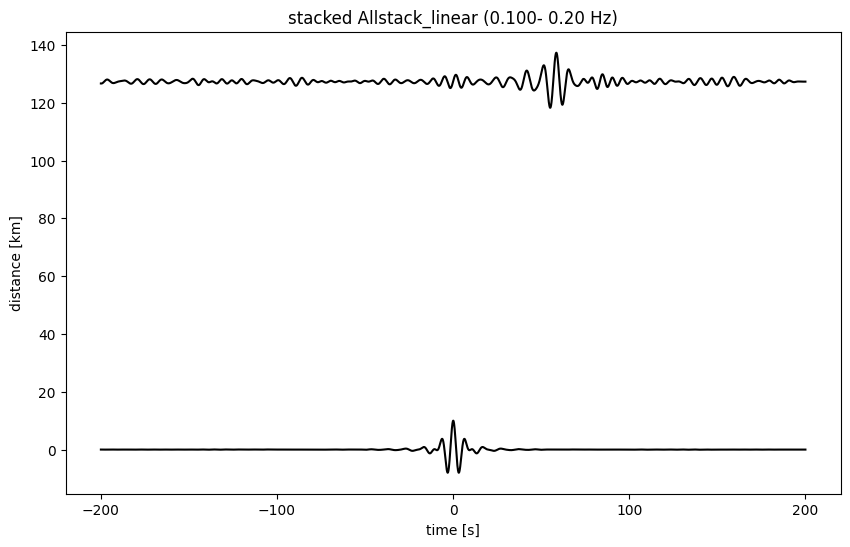

In [60]:
plot_all_moveout(sta_stacks, 'Allstack_linear', 0.1, 0.2, 'ZZ', 1)